In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt

In [2]:
# 1. 环境初始化[1,4](@ref)
env = gym.make("LunarLander-v3", render_mode="rgb_array")
state_dim = env.observation_space.shape[0]  # 状态维度：8 (位置/速度/角度等)
action_dim = env.action_space.n             # 动作维度：4 (无操作/主引擎/左/右)


In [3]:

# 2. DQN神经网络[8](@ref)
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    
    def forward(self, x):
        return self.net(x)


In [4]:


# 3. 经验回放缓存[8](@ref)
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, *args):
        self.buffer.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)



In [5]:


# 4. DQN智能体
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.policy_net = DQN(state_dim, action_dim)   # 策略网络
        self.target_net = DQN(state_dim, action_dim)   # 目标网络（稳定训练）
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-3)
        self.buffer = ReplayBuffer()
        self.batch_size = 64
        self.gamma = 0.99      # 折扣因子[8](@ref)
        self.epsilon = 1.0     # 探索率
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        
    def act(self, state):
        if np.random.rand() < self.epsilon:  # epsilon-贪婪策略[2](@ref)
            return env.action_space.sample()
        else:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                return self.policy_net(state).argmax().item()
    
    def update(self):
        if len(self.buffer) < self.batch_size:
            return
            
        # 从缓存中采样
        transitions = self.buffer.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        
        # 转换数据为张量
        state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32)
        action_batch = torch.tensor(batch.action, dtype=torch.long).unsqueeze(1)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32)
        next_state_batch = torch.tensor(np.array(batch.next_state), dtype=torch.float32)
        done_batch = torch.tensor(batch.done, dtype=torch.float32)
        
        # 计算Q值
        q_values = self.policy_net(state_batch).gather(1, action_batch)
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach()
        expected_q = reward_batch + self.gamma * next_q_values * (1 - done_batch)
        
        # 计算损失
        loss = nn.MSELoss()(q_values, expected_q.unsqueeze(1))
        
        # 优化模型
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # 更新目标网络（软更新）
        target_net_state = self.target_net.state_dict()
        policy_net_state = self.policy_net.state_dict()
        for key in policy_net_state:
            target_net_state[key] = 0.01 * policy_net_state[key] + 0.99 * target_net_state[key]
        self.target_net.load_state_dict(target_net_state)
        
        # 衰减探索率
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)



In [6]:



# 5. 训练逻辑
agent = DQNAgent(state_dim, action_dim)
episode_rewards = []

for episode in range(500):  # 训练500轮
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action = agent.act(state)  # 选择动作
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # 存储经验[8](@ref)
        agent.buffer.push(state, action, reward, next_state, done)
        agent.update()  # 更新网络
        
        state = next_state
        total_reward += reward
    
    episode_rewards.append(total_reward)
    print(f"Episode {episode}: Reward={total_reward:.2f}, Epsilon={agent.epsilon:.3f}")



Episode 0: Reward=-71.07, Epsilon=0.956
Episode 1: Reward=-335.25, Epsilon=0.513
Episode 2: Reward=-119.95, Epsilon=0.197
Episode 3: Reward=-141.97, Epsilon=0.082
Episode 4: Reward=-626.91, Epsilon=0.048
Episode 5: Reward=56.04, Epsilon=0.019
Episode 6: Reward=-87.70, Epsilon=0.010
Episode 7: Reward=-74.30, Epsilon=0.010
Episode 8: Reward=-21.74, Epsilon=0.010
Episode 9: Reward=-92.11, Epsilon=0.010
Episode 10: Reward=-93.02, Epsilon=0.010
Episode 11: Reward=-73.71, Epsilon=0.010
Episode 12: Reward=-91.02, Epsilon=0.010
Episode 13: Reward=-131.80, Epsilon=0.010
Episode 14: Reward=-42.16, Epsilon=0.010
Episode 15: Reward=-97.04, Epsilon=0.010
Episode 16: Reward=-120.57, Epsilon=0.010
Episode 17: Reward=-72.66, Epsilon=0.010
Episode 18: Reward=-132.55, Epsilon=0.010
Episode 19: Reward=-98.85, Epsilon=0.010
Episode 20: Reward=-114.56, Epsilon=0.010
Episode 21: Reward=-28.37, Epsilon=0.010
Episode 22: Reward=-117.75, Epsilon=0.010
Episode 23: Reward=-73.68, Epsilon=0.010
Episode 24: Reward

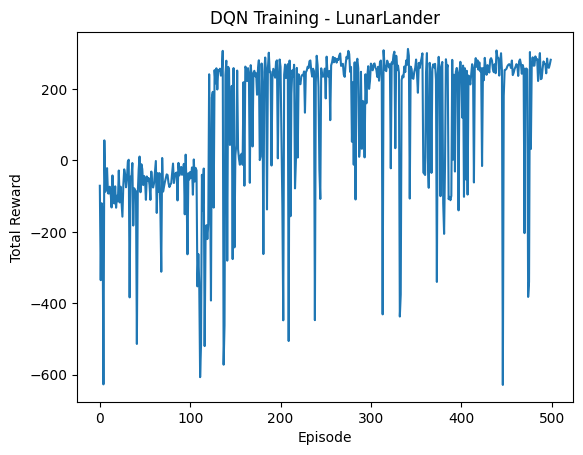

In [ ]:




# 6. 可视化训练结果
# 结果可视化
plt.plot(episode_rewards)
plt.title("LunarLander-v3 DQN Training")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.savefig('training_curve.png')



In [18]:
#7. 模型测试（不渲染窗口）
test_env = gym.make("LunarLander-v3", render_mode="rgb_array")
state, _ = test_env.reset()
while True:
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = agent.policy_net(state_tensor).argmax().item()
    next_state, _, terminated, truncated, _ = test_env.step(action)
    state = next_state
    if terminated or truncated:
        break
test_env.close()

In [20]:
import imageio

test_env = gym.make("LunarLander-v3", render_mode="rgb_array")
state, _ = test_env.reset()
frames = []
while True:
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = agent.policy_net(state_tensor).argmax().item()
    next_state, _, terminated, truncated, _ = test_env.step(action)
    frame = test_env.render()
    frames.append(frame)
    state = next_state
    if terminated or truncated:
        break
test_env.close()
imageio.mimsave('lunarlander_test.gif', frames, fps=30)